In [23]:
# Продолжайте развивать генератор данных.
# Решите задачу трекинга объектов.
# Этап 1. Генератор последовательности кадров с потоком клеток, перемещающихся "слева - направо".
#  - сгенерировать последовательность кадров в 10 секунд (итого - примерно 240 кдаров)
# - первичное положение клеток - случайный пиксель
# - при достижении границы изображения объект прекращает свое существование
# - пусть генератор пути клеток позволяет перемещать клетку по синусоиде  y(x(t) ) = ax+b + c * sin( omega *x) + eps_noise 
# - a,b,c omega - случайно сгенерированные значения для данной клетки  eps_noise - случайное значение для каждой секунды
# - a,b,c omega - случайно сгенерированные значения для данной клетки
# - 10 секунду - 10 отсчетов времени t,  положение между кажром 0 и кадром 24 интерполируется при помощи линейной интерполяции по формуле: 
# - выполнить то же самое, только зависимость не T(z),как в примере, а y(x)

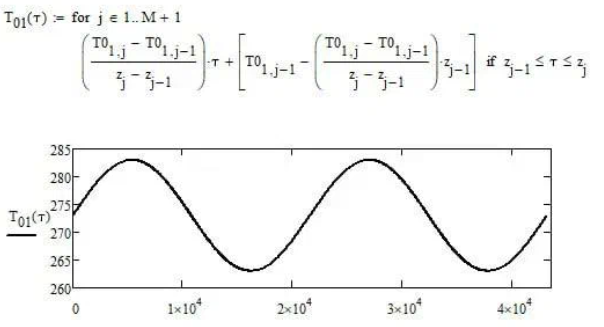

In [24]:
# Этап 2. Трекинг объектов.
# Используя пример, приведенный в лекции про трекинг, решить задачу трекинга объектов
# Пути (положения) объктов на каждом кадре сохранить в файл.
# Визуализировать траектории объектов на изображении.

Создание tracking_results.mp4: 100%|██████████| 240/240 [00:03<00:00, 69.23it/s]


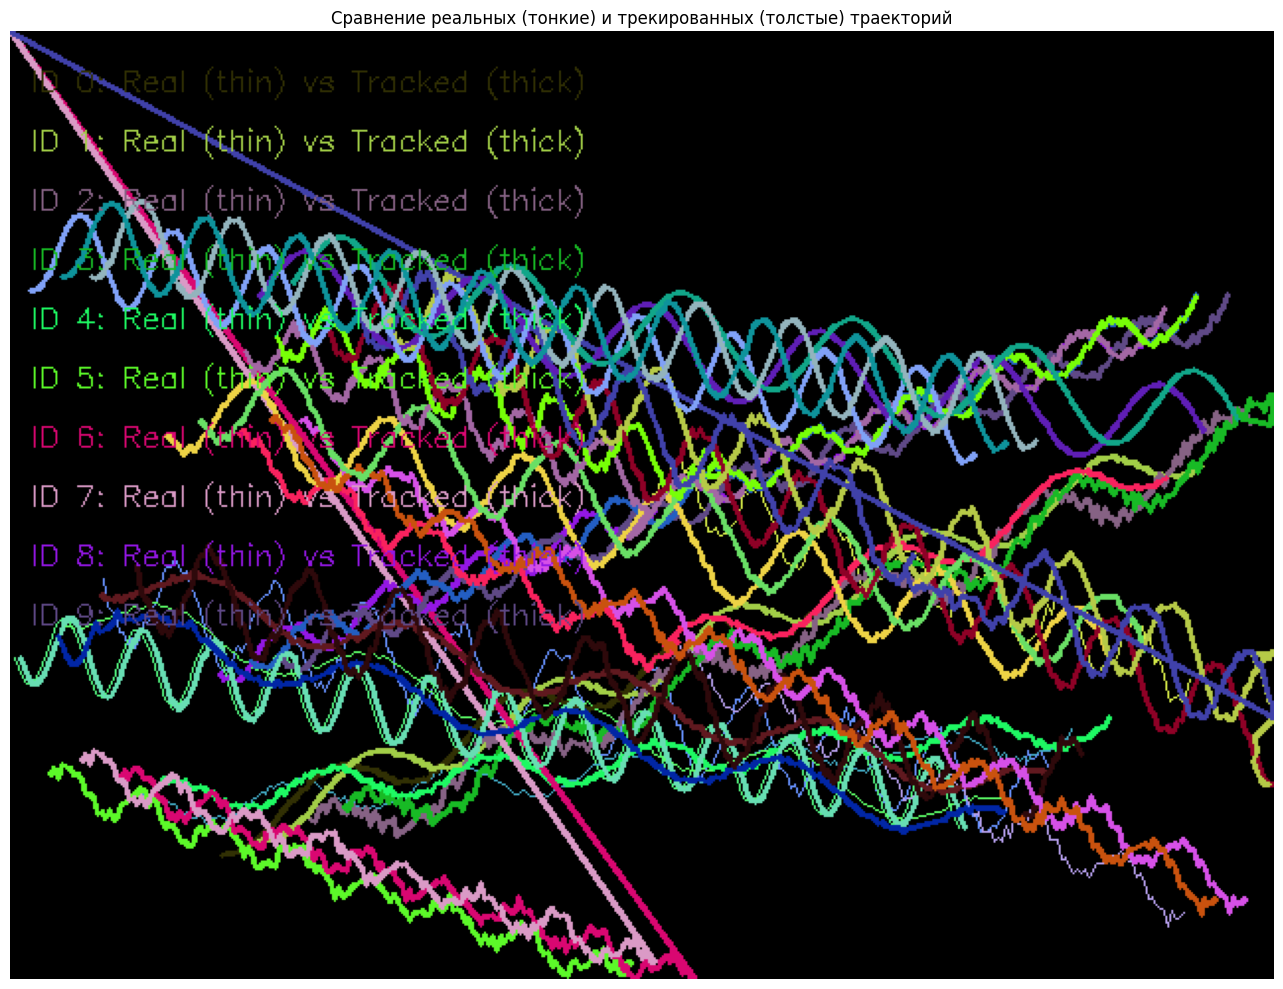

Обработка завершена. Результаты в папке task6:
- generated_sequence.mp4 - исходная последовательность
- tracking_results.mp4 - результаты трекинга
- tracking_comparison*.png - сравнение траекторий
- trajectories.txt - координаты объектов


In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import glob

os.makedirs('task6/frames', exist_ok=True)
os.makedirs('task6/tracking_results', exist_ok=True)

WIDTH, HEIGHT = 640, 480
FPS = 24
DURATION = 10  # секунд
TOTAL_FRAMES = FPS * DURATION
NUM_CELLS = 15
COLORS = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(NUM_CELLS)]

class Cell:
    def __init__(self, cell_id):
        self.id = cell_id
        self.color = COLORS[cell_id]
        self.x = random.randint(0, WIDTH//4)
        self.y = random.randint(0, HEIGHT)
        self.a = random.uniform(-0.5, 0.5)
        self.b = random.randint(0, HEIGHT)
        self.c = random.uniform(5, 30)
        self.omega = random.uniform(0.05, 0.2)
        self.noise = random.uniform(0, 5)
        self.active = True
        self.trajectory = []
        
    def update_position(self, t):
        if not self.active:
            return False
        
        self.x += 2
        noise = random.uniform(-self.noise, self.noise)
        self.y = self.a * self.x + self.b + self.c * np.sin(self.omega * self.x) + noise
        
        if self.x < 0 or self.x >= WIDTH or self.y < 0 or self.y >= HEIGHT:
            self.active = False
            return False
            
        self.trajectory.append((self.x, self.y))
        return True

def generate_frames():
    cells = [Cell(i) for i in range(NUM_CELLS)]
    active_cells = NUM_CELLS
    
    for frame_idx in tqdm(range(TOTAL_FRAMES), desc="Генерация кадров"):
        frame = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
        
        for cell in cells:
            if cell.active:
                if not cell.update_position(frame_idx / FPS):
                    active_cells -= 1
        
        # Рисуем траектории
        for cell in cells:
            if len(cell.trajectory) > 1:
                for i in range(1, len(cell.trajectory)):
                    cv2.line(frame, 
                            (int(cell.trajectory[i-1][0]), int(cell.trajectory[i-1][1])),
                            (int(cell.trajectory[i][0]), int(cell.trajectory[i][1])),
                            cell.color, 1)
        
        # Рисуем клетки
        for cell in cells:
            if cell.active:
                cv2.circle(frame, (int(cell.x), int(cell.y)), 8, cell.color, -1)
                cv2.putText(frame, str(cell.id), (int(cell.x)+10, int(cell.y)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imwrite(f'task6/frames/frame_{frame_idx:04d}.png', frame)
        
        if active_cells <= 0:
            break
    
    return cells

def track_objects():
    tracker = cv2.legacy.MultiTracker_create()
    frame_files = sorted(glob.glob('task6/frames/frame_*.png'))
    trajectories = defaultdict(list)
    
    # Инициализация по первому кадру
    first_frame = cv2.imread(frame_files[0])
    gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Генерация цветов для найденных объектов
    tracking_colors = []
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > 20:
            tracking_colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    
    # Инициализация трекеров
    bboxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            bboxes.append((x, y, w, h))
    
    for bbox in bboxes:
        tracker.add(cv2.legacy.TrackerCSRT_create(), first_frame, bbox)
    
    # Обработка кадров
    for frame_idx, frame_file in enumerate(tqdm(frame_files, desc="Трекинг объектов")):
        frame = cv2.imread(frame_file)
        success, boxes = tracker.update(frame)
        
        # Улучшенная визуализация
        for i, box in enumerate(boxes):
            if i >= len(tracking_colors):  # Защита от выхода за границы
                continue
                
            x, y, w, h = box
            center = (int(x + w/2), int(y + h/2))
            trajectories[i].append(center)
            
            # Рисуем bounding box с прозрачным фоном
            overlay = frame.copy()
            cv2.rectangle(overlay, (int(x), int(y)), (int(x + w), int(y + h)), 
                         tracking_colors[i], 2)
            cv2.addWeighted(overlay, 0.5, frame, 0.5, 0, frame)
            
            # Рисуем ID и траекторию
            cv2.putText(frame, f"ID:{i}", (int(x), int(y)-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, tracking_colors[i], 2)
            
            if len(trajectories[i]) > 1:
                for j in range(1, len(trajectories[i])):
                    cv2.line(frame, trajectories[i][j-1], trajectories[i][j], 
                            tracking_colors[i], 2)
        
        cv2.imwrite(frame_file.replace('frames', 'tracking_results'), frame)
    
    return trajectories, tracking_colors

def visualize_results(trajectories, generated_cells, tracking_colors=None):
    """Визуализация результатов трекинга с улучшенным отображением"""
    final_vis = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
    
    # Рисуем исходные траектории (тонкие линии)
    for cell in generated_cells:
        if len(cell.trajectory) > 1:
            for i in range(1, len(cell.trajectory)):
                cv2.line(final_vis,
                        (int(cell.trajectory[i-1][0]), int(cell.trajectory[i-1][1])),
                        (int(cell.trajectory[i][0]), int(cell.trajectory[i][1])),
                        cell.color, 1)
    
    # Рисуем трекированные траектории (толстые линии)
    if isinstance(trajectories, dict):  # Если переданы только trajectories
        for obj_id, points in trajectories.items():
            if len(points) > 1:
                color = tracking_colors[obj_id] if tracking_colors else COLORS[obj_id % len(COLORS)]
                for i in range(1, len(points)):
                    cv2.line(final_vis, points[i-1], points[i], color, 2)
    else:  # Если переданы (trajectories, tracking_colors)
        trajectories_dict = trajectories[0] if isinstance(trajectories, tuple) else trajectories
        colors = tracking_colors if tracking_colors else COLORS
        for obj_id, points in trajectories_dict.items():
            if len(points) > 1:
                color = colors[obj_id % len(colors)]
                for i in range(1, len(points)):
                    cv2.line(final_vis, points[i-1], points[i], color, 2)
    
    # Добавляем легенду
    legend_items = min(10, len(generated_cells))
    for i in range(legend_items):
        color = tracking_colors[i] if tracking_colors else COLORS[i]
        cv2.putText(final_vis, f"ID {i}: Real (thin) vs Tracked (thick)", 
                   (10, 30 + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    # Сохраняем и отображаем
    cv2.imwrite('task6/tracking_comparison.png', final_vis)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(final_vis, cv2.COLOR_BGR2RGB))
    plt.title("Сравнение реальных (тонкие) и трекированных (толстые) траекторий")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('task6/tracking_comparison_plot.png')
    plt.show()

def create_video(input_pattern, output_name):
    frame_files = sorted(glob.glob(input_pattern))
    if not frame_files:
        print("Нет файлов для создания видео!")
        return
    
    # Определяем размеры из первого кадра
    first_frame = cv2.imread(frame_files[0])
    height, width, _ = first_frame.shape
    
    # Создаем видео в формате MP4
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'task6/{output_name}.mp4', fourcc, FPS, (width, height))
    
    for filename in tqdm(frame_files, desc=f"Создание {output_name}.mp4"):
        img = cv2.imread(filename)
        out.write(img)
    
    out.release()

if __name__ == "__main__":
    # Генерация данных
    generated_cells = generate_frames()
    create_video('task6/frames/frame_*.png', 'generated_sequence')
    
    # Трекинг
    trajectories, tracking_colors = track_objects()
    create_video('task6/tracking_results/frame_*.png', 'tracking_results')
    
    # Визуализация
    visualize_results(trajectories, generated_cells, tracking_colors)
    
    # Сохранение траекторий
    with open('task6/trajectories.txt', 'w') as f:
        for obj_id, points in trajectories.items():
            f.write(f"Object {obj_id}:\n")
            for point in points:
                f.write(f"{point[0]}, {point[1]}\n")
            f.write("\n")
    
    print("Обработка завершена. Результаты в папке task6:")
    print("- generated_sequence.mp4 - исходная последовательность")
    print("- tracking_results.mp4 - результаты трекинга")
    print("- tracking_comparison*.png - сравнение траекторий")
    print("- trajectories.txt - координаты объектов")